<center><h1 style="font-size:40px;">Regression using Recurrent Neural Networks</h1></center>

Welcome to this lab session! Today, we will be diving into the fascinating world of Recurrent Neural Networks (RNNs) and exploring their use in regression tasks.

By the end of this lab session, you will be able to:

* Understand the basic concepts behind Recurrent Neural Networks and how they work.
* Implement different architectures to include recurrent neural networks.
* Apply these RNN architectures to solve regression problems.
* Evaluate the performance of your models and understand their strengths and limitations.

In [1]:
# select a gpu
import os

os.environ["CUDA_VISIBLE_DEV ICES"] = "3"

In [2]:
# autoreload imports
%load_ext autoreload
%autoreload 2

In [3]:
import random
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import cv2
import torch.optim as optim
import matplotlib.pyplot as plt

## dataset 

In [4]:
# Convert angles to 2D vectors
def angle_to_vector_np(angles_rad):
    return np.cos(angles_rad), np.sin(angles_rad)


# Convert degrees to radians
def deg_to_rad(deg):
    return deg * np.pi / 180


# Convert radians to degrees
def rad_to_deg(rad):
    return rad * 180 / np.pi


# Convert angles to 2D vectors
def angle_to_vector(angles):
    angles_rad = deg_to_rad(angles)
    return torch.cos(angles_rad), torch.sin(angles_rad)


# Convert 2D vectors to angles
def vector_to_angle(vectors):
    return rad_to_deg(torch.atan2(vectors[1], vectors[0]))


# Convert 2D vectors to angles
def vector_to_angle_np(vectors):
    return rad_to_deg(np.arctan2(vectors[1], vectors[0]))

In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


def animate_datapoint(x, y):
    fig = plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title("Angle: {:.1f}".format(vector_to_angle_np(y)))
    ims = []
    for frame in x:
        if isinstance(frame, torch.Tensor):
            frame = frame.permute(1, 2, 0).numpy() * 255
        im = plt.imshow(frame.astype(np.uint8))
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000)
    return ani


def animate_datapoint_with_direction(x, y, center, pred=None, pred_color="red"):
    """
    This function creates an animation of a data point with a direction arrow. Use this function to visualize the data points in the training, validation, and test sets.
    You can also use this function to visualize the predictions of your model, by providing the predicted direction vector as the `pred` parameter.
    In case the object color is interfering with the visibility of the direction arrow, you can change the color of the predicted direction arrow using the `pred_color` parameter.

    Parameters:
    x (array-like or torch.Tensor): The frames to be animated. If frames are torch.Tensor, they will be converted to numpy arrays.
    y (array-like): The direction vector for the arrow in the animation.
    center (tuple): The starting point (center) of the arrow.
    pred (array-like, optional): The predicted direction vector for the arrow in the animation. If provided, an additional arrow showing the predicted direction will be drawn. Defaults to None.
    pred_color (str, optional): The color of the predicted direction arrow. Defaults to "red".

    Returns:
    matplotlib.animation.ArtistAnimation: The resulting animation object.
    """

    fig = plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title("Angle: {:.1f}".format(vector_to_angle_np(y)))

    ims = []
    for frame in x:
        if isinstance(frame, torch.Tensor):
            frame = frame.permute(1, 2, 0).numpy() * 255
        im = plt.imshow(frame.astype(np.uint8))
        arrow = plt.arrow(
            center[0],
            center[1],
            y[0] * 4,
            y[1] * -4,
            head_width=3,
            head_length=5,
            fc="black",
            ec="black",
        )
        if pred is not None:
            arrow_pred = plt.arrow(
                center[0],
                center[1],
                pred[0] * 4,
                pred[1] * -4,
                head_width=3,
                head_length=5,
                fc=pred_color,
                ec=pred_color,
            )
            ims.append([im, arrow, arrow_pred])
        else:
            ims.append([im, arrow])

    ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000)
    return ani

In [6]:
def generate_dataset(
    num_samples,
    canvas_size=(64, 64),
    shapes=["circle", "triangle", "square"],
    colors={
        "blue": (255, 0, 0),
        "yellow": (0, 255, 255),
        "red": (0, 0, 255),
        "gray": (128, 128, 128),
        "green": (0, 255, 0),
        "purple": (255, 0, 255),
    },
):
    """
    Generates a dataset of random shapes moving in a straight line in random directions.

    Parameters:
    num_samples (int): The number of samples to generate.
    canvas_size (tuple): The size of the canvas for each sample. Defaults to (64, 64).
    shapes (list): The shapes to be used in the dataset. Defaults to ["circle", "triangle", "square"].
    num_frames (int): The number of frames for each sample. Defaults to 30.
    colors (dict): The colors to be used for the shapes. Defaults to a dictionary of BGR color values.
    step_size (float): The step size for the movement of the shapes. Defaults to 0.5.

    Returns:
    tuple: A tuple containing the following elements:
        - dataset (numpy.ndarray): The generated dataset. Shape is (num_samples, num_frames, canvas_size[0], canvas_size[1], 3).
        - labels (numpy.ndarray): The labels for each sample. Shape is (num_samples,).
        - centers (list): The center positions for each shape.
    """

    labels_list = []
    centers_list = []
    shapes_list = []
    angles_deg_list = []
    sizes_list = []
    colors_list = []

    for i in range(num_samples):
        shape = np.random.choice(shapes)
        position = np.random.rand(2) * (np.array(canvas_size) - 1)
        size = np.random.randint(4, 10)
        angle_deg = np.random.uniform(0, 360)
        angle_rad = np.radians(angle_deg)
        color = colors[np.random.choice(list(colors.keys()))]
        colors_list.append(color)

        labels_list.append(angle_to_vector_np(angle_rad))
        centers_list.append(position.copy())
        shapes_list.append(shape)
        angles_deg_list.append(angle_deg)
        sizes_list.append(size)

    return (
        labels_list,
        centers_list,
        shapes_list,
        angles_deg_list,
        sizes_list,
        colors_list,
    )


def generate_frames(
    num_frames,
    center,
    angle_deg,
    canvas_size,
    shape,
    size,
    color,
    step_size=0.5,
):
    frames = np.zeros((num_frames, canvas_size[0], canvas_size[1], 3))
    angle_rad = np.radians(angle_deg)
    direction = np.array([np.cos(angle_rad), -np.sin(angle_rad)]) * step_size

    center = center.copy()

    for i in range(num_frames):
        canvas = np.ones((canvas_size[0], canvas_size[1], 3), dtype=np.uint8) * 255

        if shape == "circle":
            cv2.circle(canvas, tuple(center.astype(int)), size, color, -1)
        elif shape == "triangle":
            points = np.array(
                [
                    [center[0], center[1]],
                    [center[0] + size, center[1]],
                    [center[0] + size // 2, center[1] - size],
                ]
            )
            points = points.reshape((-1, 1, 2)).astype(int)
            cv2.fillPoly(canvas, [points], color=color)
        elif shape == "square":
            top_left = (int(center[0] - size // 2), int(center[1] - size // 2))
            bottom_right = (int(center[0] + size // 2), int(center[1] + size // 2))
            cv2.rectangle(canvas, top_left, bottom_right, color, -1)

        frames[i] = canvas

        # Update the center based on the direction and step size.
        center += direction

    return frames

In [7]:
class MovingShapesDataset(Dataset):
    def __init__(self, num_samples, num_frames, transform=None, canvas_size=(64, 64)):
        self.num_samples = num_samples
        self.num_frames = num_frames
        self.canvas_size = canvas_size
        (
            self.labels,
            self.centers,
            self.shapes,
            self.angles_deg,
            self.sizes,
            self.colors,
        ) = generate_dataset(num_samples)

        self.transform = transform
        
    def __len__(self):
        return self.num_samples

    
    def __getitem__(self, idx):
        label, center, shape, angle_deg, size, color = (
            self.labels[idx],
            self.centers[idx],
            self.shapes[idx],
            self.angles_deg[idx],
            self.sizes[idx],
            self.colors[idx],
        )
        frames = generate_frames(
            self.num_frames, center, angle_deg, self.canvas_size, shape, size, color
        )
        frames = torch.from_numpy(frames).float() / 255.0
        if self.transform:
            frames, label = self.transform((frames, label))
        return (
            frames.permute(0, 3, 1, 2),
            np.array(label),
            center,
        )  # center is added for plotting purposes, you are not allowed to use it in the network

In [8]:
train_dataset = MovingShapesDataset(num_samples=100000, num_frames=20)
val_dataset = MovingShapesDataset(num_samples=1000, num_frames=20)
test_dataset = MovingShapesDataset(num_samples=1000, num_frames=20)

In [9]:
index = random.randint(0, len(train_dataset) - 1)
sample_data, sample_label, sample_initial_position = train_dataset[index]

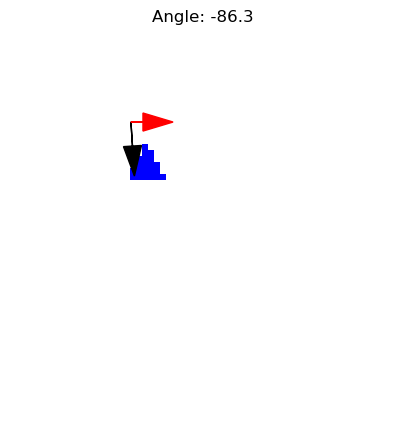

In [10]:
ani = animate_datapoint_with_direction(
    sample_data, sample_label, sample_initial_position, pred=(0.5, 0)
)
HTML(ani.to_jshtml())

## TASK 1

#TODO Define CNN model to predict the angle of movement. You are encouraged to use the models from torchvision. You can also use the models from the previous lab. Do not forget to change the output layer dimension. And using the proper training scripts from the previous labs, train the model. How the model is doing? 

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        dummy_input = torch.zeros(1, 3, 20, 64, 64)  
        dummy_output = self.conv_forward(dummy_input)
        self.flattened_dim = dummy_output.numel()

        self.fc1 = nn.Linear(in_features=self.flattened_dim, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)  

    def conv_forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        return x

    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(-1, self.flattened_dim)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        data, labels, _ = batch
        data = data.permute(0, 2, 1, 3, 4).float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data, labels, _ = batch
            data = data.permute(0, 2, 1, 3, 4).float().to(device)
            labels = labels.float().to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    return avg_train_loss, avg_val_loss


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 40  
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    avg_train_loss, avg_val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Epoch 1/40 - Training Loss: 79.0195, Validation Loss: 0.1841
Epoch 2/40 - Training Loss: 0.2245, Validation Loss: 0.1265
Epoch 3/40 - Training Loss: 0.2434, Validation Loss: 0.4341
Epoch 4/40 - Training Loss: 0.2005, Validation Loss: 0.0745
Epoch 5/40 - Training Loss: 0.0588, Validation Loss: 0.0601
Epoch 6/40 - Training Loss: 0.0662, Validation Loss: 0.0361
Epoch 7/40 - Training Loss: 0.0250, Validation Loss: 0.0252
Epoch 8/40 - Training Loss: 0.0189, Validation Loss: 0.0251
Epoch 9/40 - Training Loss: 0.0157, Validation Loss: 0.0223
Epoch 10/40 - Training Loss: 0.0132, Validation Loss: 0.0200
Epoch 11/40 - Training Loss: 0.0116, Validation Loss: 0.0208
Epoch 12/40 - Training Loss: 0.0103, Validation Loss: 0.0190
Epoch 13/40 - Training Loss: 0.0094, Validation Loss: 0.0180
Epoch 14/40 - Training Loss: 0.0084, Validation Loss: 0.0186
Epoch 15/40 - Training Loss: 0.0076, Validation Loss: 0.0199
Epoch 16/40 - Training Loss: 0.0073, Validation Loss: 0.0168
Epoch 17/40 - Training Loss: 0.0

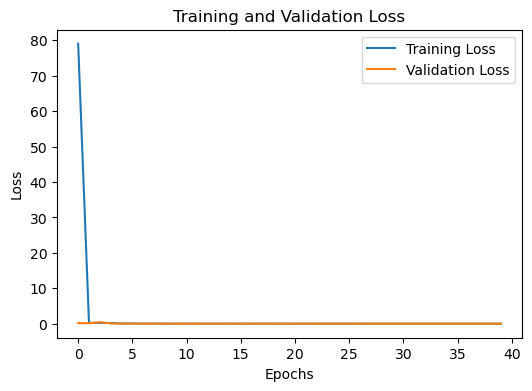

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The model seems to be performing well, both training and validation loss values decrease over the epochs.



## TASK 2

#TODO Define Recurrent neural network model to predict the angle of movement. And using the proper training scripts from the previous labs, train the model. How the model is doing? 

You can have a look at the following skeleton of a basic recurrent model in pytorch. Keep mind that is just a basic starting point. Have look at the [pytorch LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and adding more layers, dropout, bidirectionality and so on

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.5, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.factor = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, 
                            dropout=dropout, 
                            bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.factor, output_size)

    def forward(self, x):
        batch_size, seq_length, input_size = x.shape
        h0 = torch.zeros(self.num_layers * self.factor, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.factor, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [14]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        data, labels, _ = batch
        data = data.reshape(data.size(0), data.size(1), -1).float().to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data, labels, _ = batch
            data = data.reshape(data.size(0), data.size(1), -1).float().to(device)
            labels = labels.float().to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    return avg_train_loss, avg_val_loss


In [15]:
image_width = 64
image_height = 64
num_color_channels = 3  
input_size = image_width * image_height * num_color_channels  
hidden_size = 256
output_size = 2 
num_layers = 2
dropout = 0.3
bidirectional = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout, bidirectional)
model.to(device)  

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [25]:
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    avg_train_loss, avg_val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch 1/30 - Training Loss: 0.5010, Validation Loss: 0.4996
Epoch 2/30 - Training Loss: 0.5007, Validation Loss: 0.5001
Epoch 3/30 - Training Loss: 0.5005, Validation Loss: 0.5013
Epoch 4/30 - Training Loss: 0.5004, Validation Loss: 0.5004
Epoch 5/30 - Training Loss: 0.5003, Validation Loss: 0.4999
Epoch 6/30 - Training Loss: 0.5002, Validation Loss: 0.5004
Epoch 7/30 - Training Loss: 0.5002, Validation Loss: 0.5006
Epoch 8/30 - Training Loss: 0.5001, Validation Loss: 0.5001
Epoch 9/30 - Training Loss: 0.5001, Validation Loss: 0.5004
Epoch 10/30 - Training Loss: 0.5001, Validation Loss: 0.5008
Epoch 11/30 - Training Loss: 0.5001, Validation Loss: 0.5005
Epoch 12/30 - Training Loss: 0.5001, Validation Loss: 0.4999
Epoch 13/30 - Training Loss: 0.5001, Validation Loss: 0.5002
Epoch 14/30 - Training Loss: 0.5000, Validation Loss: 0.5002
Epoch 15/30 - Training Loss: 0.5001, Validation Loss: 0.5001
Epoch 16/30 - Training Loss: 0.5000, Validation Loss: 0.5000
Epoch 17/30 - Training Loss: 0.50

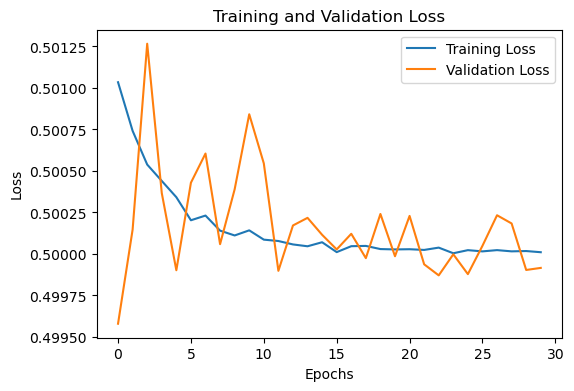

In [26]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training and validation loss values are very close and do not show significant improvement over the epochs.
This means the model is not learning much.

## TASK 3

#TODO Define a CNN + LSTM model to predict the angle of movement. You should do so by passing the features learned from the CNN model you have defined to LSTM module. In another words, you can insert a LSTM layer in between the conv layers and fully connected layers in the CNN model you have defined. This should learn the temporal features in between the frames. Does this model achieve better results? 

In [16]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    total_train_loss = 0
    for batch_idx, (data, labels, _) in enumerate(train_loader):
        data = data.float().to(device)  
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, labels, _) in enumerate(val_loader):
            data = data.float().to(device)  
            labels = labels.float().to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    return avg_train_loss, avg_val_loss


In [17]:
class CNNLSTM(nn.Module):
    def __init__(self, lstm_hidden_size, lstm_layers, bidirectional=False):
        super(CNNLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers
        self.bidirectional = bidirectional
        self.factor = 2 if bidirectional else 1

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.lstm = nn.LSTM(16 * 16 * 128, lstm_hidden_size, lstm_layers, batch_first=True, bidirectional=bidirectional)

        self.fc1 = nn.Linear(lstm_hidden_size * self.factor, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        batch_size, seq_length, C, H, W = x.size()

        cnn_out = []
        for t in range(seq_length):
            frame = x[:, t, :, :, :]
            frame_out = self.pool(F.relu(self.conv1(frame)))
            frame_out = self.pool(F.relu(self.conv2(frame_out)))

            cnn_out.append(frame_out.reshape(batch_size, -1))

        cnn_out = torch.stack(cnn_out, dim=1)  

        h0 = torch.zeros(self.lstm_layers * self.factor, batch_size, self.lstm_hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm_layers * self.factor, batch_size, self.lstm_hidden_size).to(x.device)
        lstm_out, _ = self.lstm(cnn_out, (h0, c0))

        out = F.relu(self.fc1(lstm_out[:, -1, :]))
        out = self.fc2(out)

        return out

In [18]:
seq_length = 20  
lstm_hidden_size = 256
lstm_layers = 2
bidirectional = False
model = CNNLSTM(lstm_hidden_size, lstm_layers, bidirectional).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00194)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
num_epochs = 30 
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/30 - Training Loss: 0.5004, Validation Loss: 0.4997
Epoch 2/30 - Training Loss: 0.5001, Validation Loss: 0.5002
Epoch 3/30 - Training Loss: 0.5001, Validation Loss: 0.5025
Epoch 4/30 - Training Loss: 0.5001, Validation Loss: 0.5004
Epoch 5/30 - Training Loss: 0.5001, Validation Loss: 0.4990
Epoch 6/30 - Training Loss: 0.5001, Validation Loss: 0.5001
Epoch 7/30 - Training Loss: 0.5001, Validation Loss: 0.4996
Epoch 8/30 - Training Loss: 0.5001, Validation Loss: 0.5000
Epoch 9/30 - Training Loss: 0.5001, Validation Loss: 0.4995
Epoch 10/30 - Training Loss: 0.5002, Validation Loss: 0.5008
Epoch 11/30 - Training Loss: 0.5001, Validation Loss: 0.4996
Epoch 12/30 - Training Loss: 0.5001, Validation Loss: 0.5005
Epoch 13/30 - Training Loss: 0.5001, Validation Loss: 0.5004
Epoch 14/30 - Training Loss: 0.5001, Validation Loss: 0.5000
Epoch 15/30 - Training Loss: 0.5001, Validation Loss: 0.5007
Epoch 16/30 - Training Loss: 0.5001, Validation Loss: 0.5016
Epoch 17/30 - Training Loss: 0.50

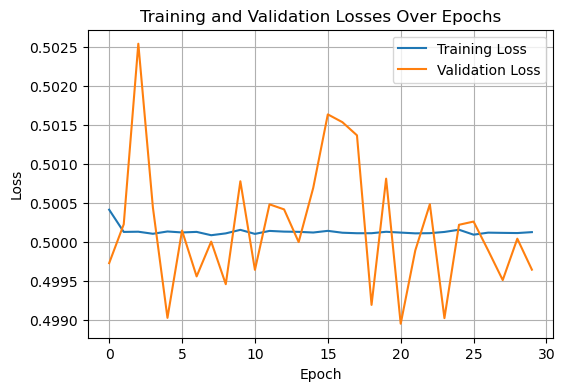

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

There is no significant improvement over the epochs. 

## TASK 4

#TODO Define a ConvLSTM model to predict the angle of movement. You should have a look at the lecture to refresh your memory on the mechanisms behind this. Does this model achieve better results? 

We have included an [implementation of the ConvLSTM](https://github.com/ndrplz/ConvLSTM_pytorch/tree/master) for the convenience. You can use this as a building block in your ConvLSTM model

In [19]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (
            torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
            torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
        )

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim, batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)
        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)

        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError("Inconsistent list length.")

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        self.cell_list = nn.ModuleList([
            ConvLSTMCell(input_dim=self.input_dim if i == 0 else self.hidden_dim[i - 1],
                         hidden_dim=self.hidden_dim[i],
                         kernel_size=self.kernel_size[i],
                         bias=self.bias)
            for i in range(self.num_layers)
        ])

        self.fc = nn.Linear(hidden_dim[-1], output_dim)

    def forward(self, input_tensor, hidden_state=None):
        if not self.batch_first:
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        last_layer_output = layer_output_list[-1]
        last_time_step_output = last_layer_output[:, -1, :, :, :]

        last_time_step_output = nn.functional.adaptive_avg_pool2d(last_time_step_output, (1, 1))
        last_time_step_output = last_time_step_output.view(last_time_step_output.size(0), -1)

        out = self.fc(last_time_step_output)

        return out

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError("`kernel_size` must be tuple or list of tuples")

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        return param if isinstance(param, list) else [param] * num_layers


In [20]:
input_dim = 3  
hidden_dim = [64, 64]  
kernel_size = (3, 3)  
num_layers = 2  
output_dim = 2  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, output_dim, batch_first=True).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [27]:
train_losses = []
val_losses = []
num_epochs = 30  

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        data, labels = batch[0].to(device).float(), batch[1].to(device).float()
        optimizer.zero_grad()
        output = model(data)
        output = output.view(output.size(0), -1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data, labels = batch[0].to(device).float(), batch[1].to(device).float()
            output = model(data)
            output = output.view(output.size(0), -1)
            loss = criterion(output, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch 1/30, Train Loss: 0.5001, Validation Loss: 0.5003
Epoch 2/30, Train Loss: 0.5001, Validation Loss: 0.4999
Epoch 3/30, Train Loss: 0.5001, Validation Loss: 0.4998
Epoch 4/30, Train Loss: 0.5001, Validation Loss: 0.5003
Epoch 5/30, Train Loss: 0.5001, Validation Loss: 0.5003
Epoch 6/30, Train Loss: 0.5001, Validation Loss: 0.5002
Epoch 7/30, Train Loss: 0.5001, Validation Loss: 0.5002
Epoch 8/30, Train Loss: 0.5001, Validation Loss: 0.5004
Epoch 9/30, Train Loss: 0.5001, Validation Loss: 0.5000
Epoch 10/30, Train Loss: 0.5001, Validation Loss: 0.5002
Epoch 11/30, Train Loss: 0.5001, Validation Loss: 0.5001
Epoch 12/30, Train Loss: 0.5001, Validation Loss: 0.4998
Epoch 13/30, Train Loss: 0.5001, Validation Loss: 0.5004
Epoch 14/30, Train Loss: 0.5001, Validation Loss: 0.5001
Epoch 15/30, Train Loss: 0.5001, Validation Loss: 0.5001
Epoch 16/30, Train Loss: 0.5001, Validation Loss: 0.5003
Epoch 17/30, Train Loss: 0.5001, Validation Loss: 0.5004
Epoch 18/30, Train Loss: 0.5001, Validat

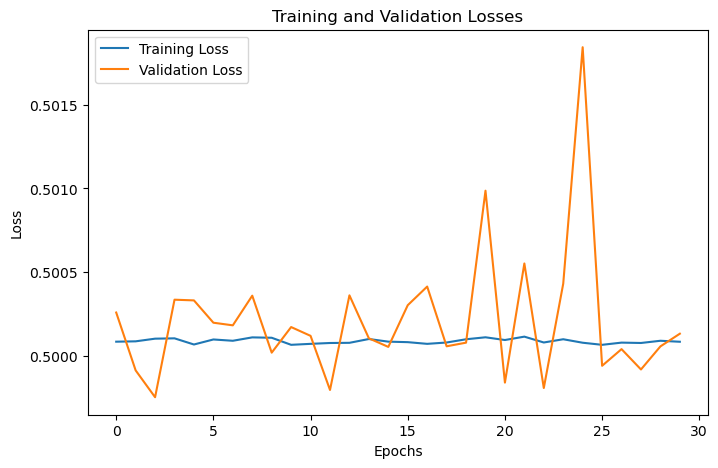

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This model does not appear to achieve better results compared to the previous models!
